## Forecasting N₂O Emissions using Prophet

This notebook trains multiple [Prophet](https://facebook.github.io/prophet/) models to forecast nitrous oxide (N₂O) emissions over defined time periods.  
For each period, a custom model is fitted, evaluated (MAE, RMSE, R²), and visualized with forecast plots and component analysis.  
Results are saved for comparison across periods.

In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



=== Period 1: 2016-01-01 to 2016-03-31 ===


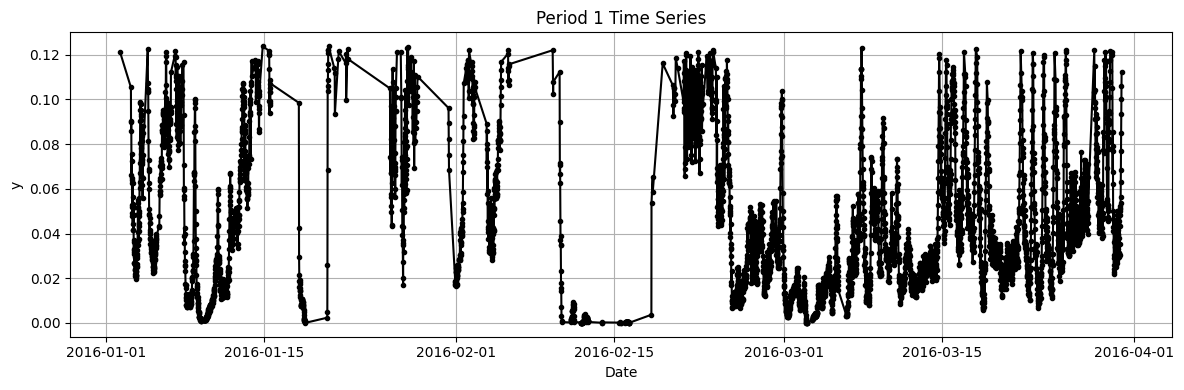

14:34:57 - cmdstanpy - INFO - Chain [1] start processing
14:34:57 - cmdstanpy - INFO - Chain [1] done processing


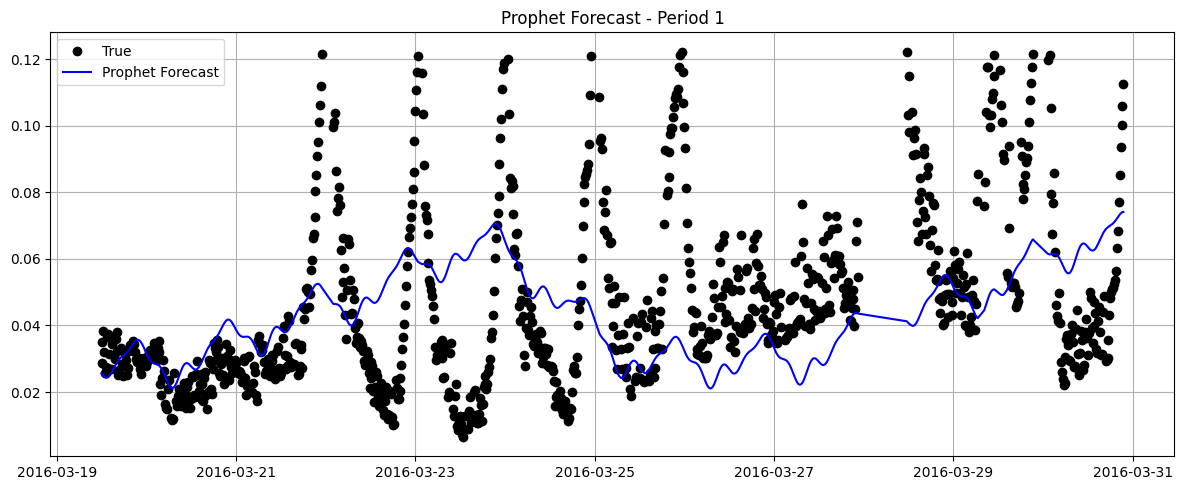



=== Period 2: 2016-03-01 to 2016-05-15 ===


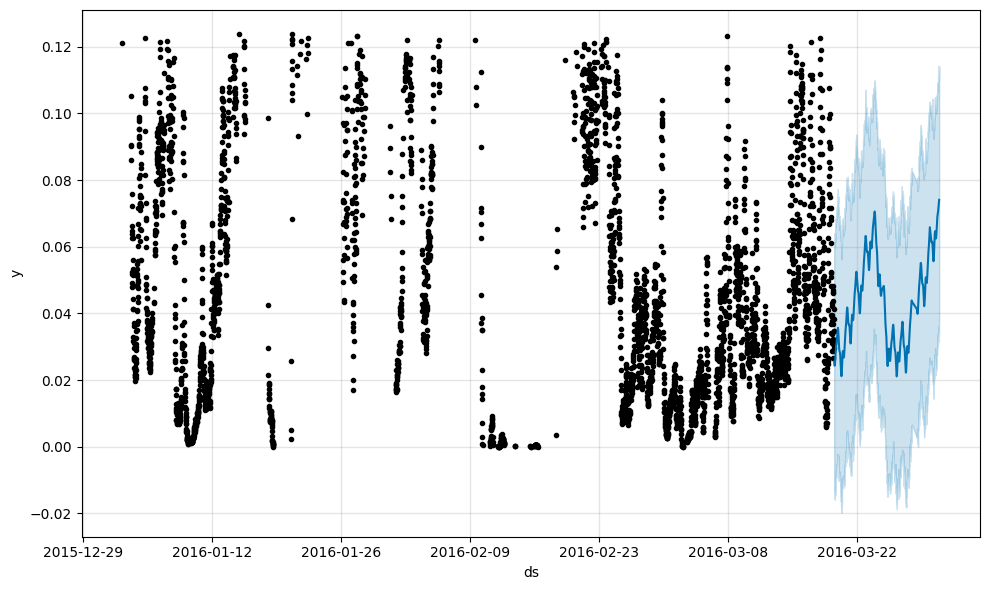

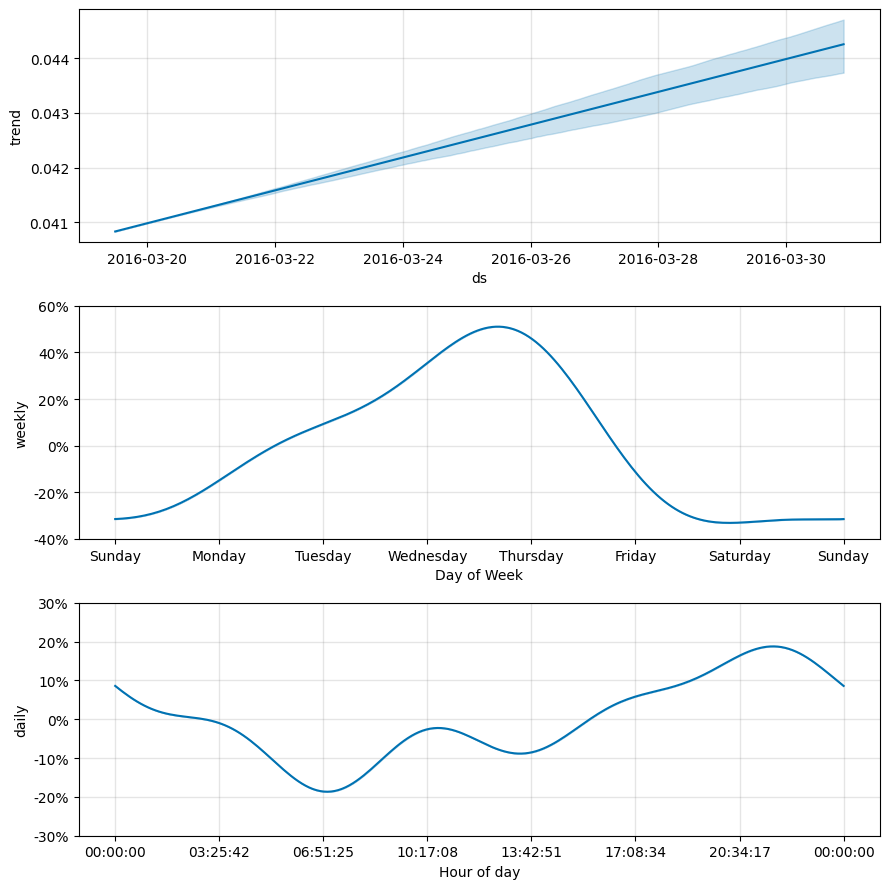

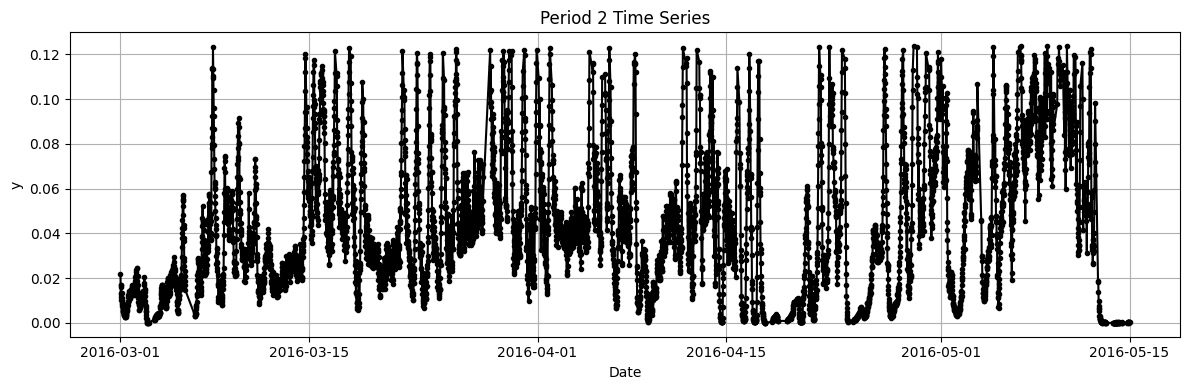

14:34:59 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] done processing


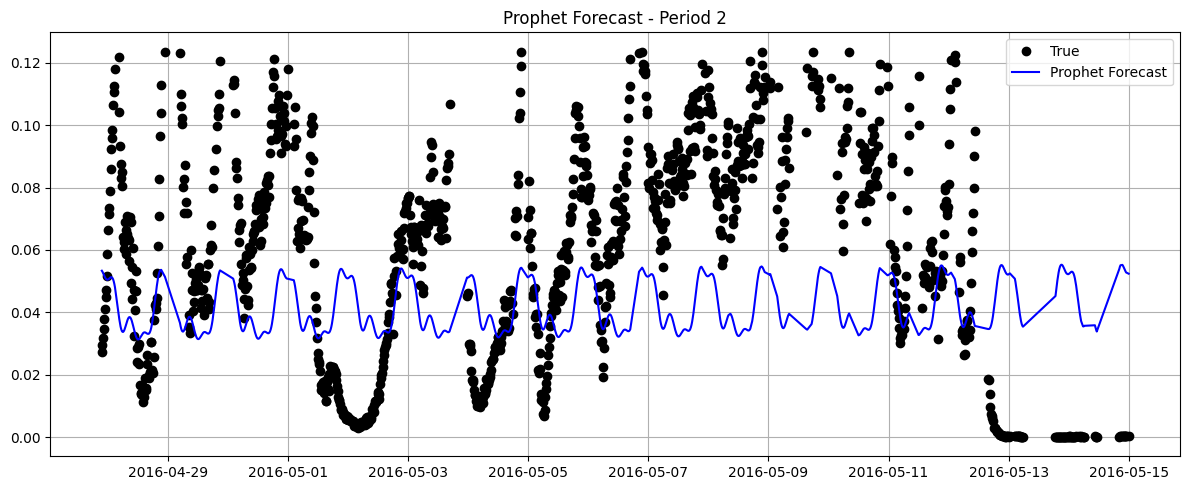



=== Period 3: 2016-05-15 to 2016-10-31 ===


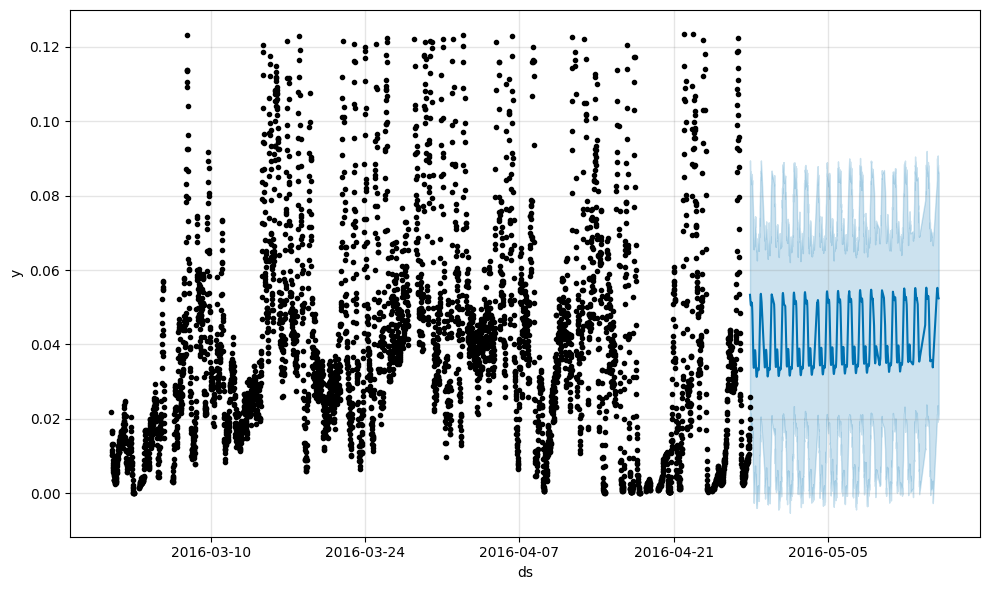

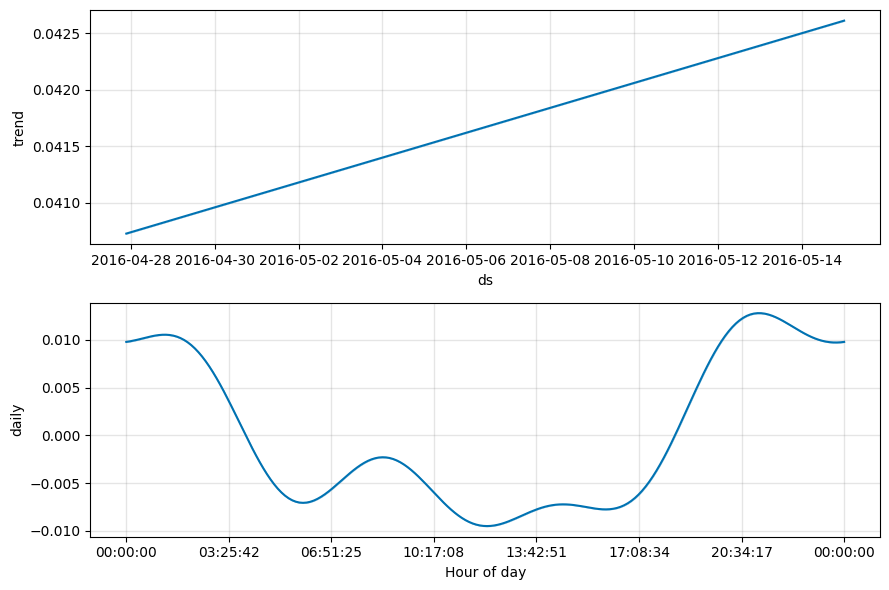

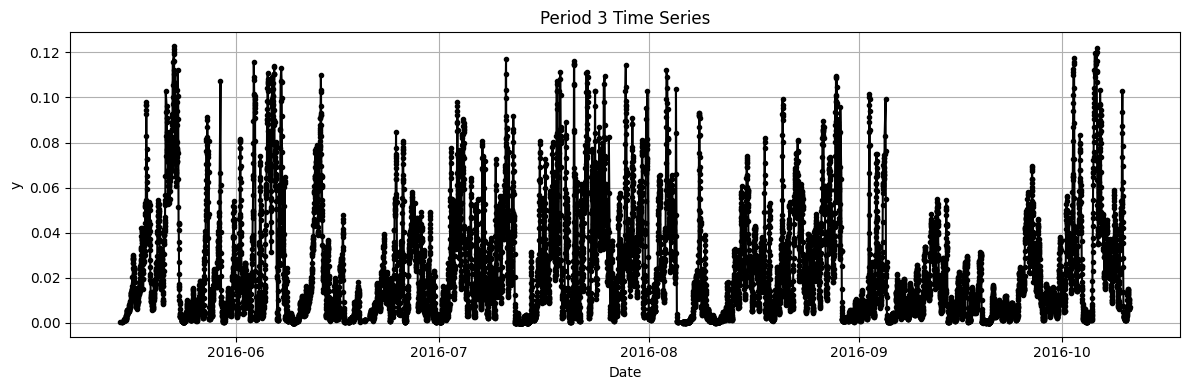

14:35:02 - cmdstanpy - INFO - Chain [1] start processing
14:35:04 - cmdstanpy - INFO - Chain [1] done processing


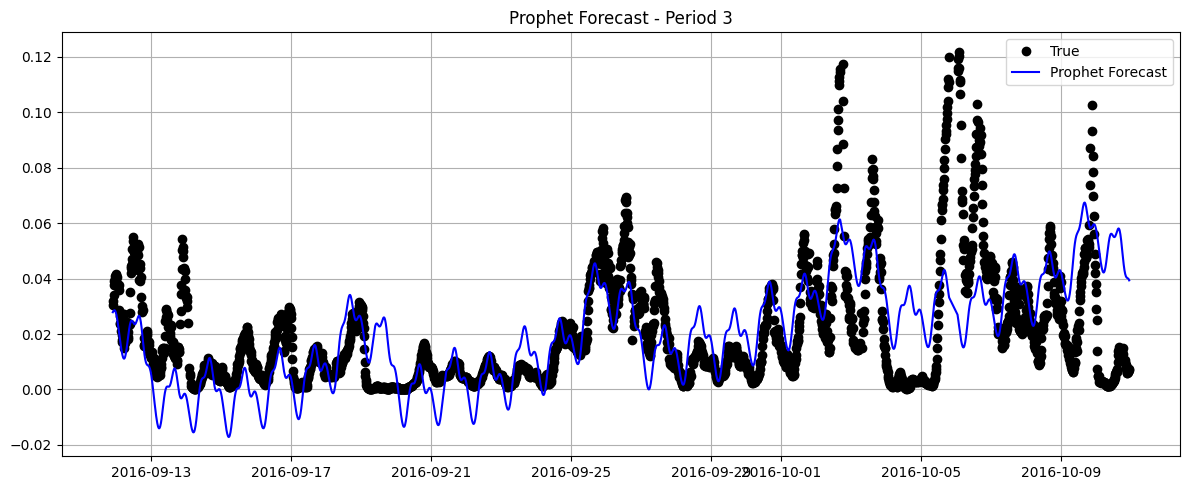


All metrics saved to 'Prophet_metrics_by_period.csv'
     Period  MAE_Train  RMSE_Train  R2_Train  MAE_Test  RMSE_Test   R2_Test
0  Period 1   0.023639    0.030041  0.190488  0.020538   0.026829 -0.085451
1  Period 2   0.020421    0.026113  0.077141  0.033396   0.038836 -0.254861
2  Period 3   0.015567    0.020513  0.274529  0.013429   0.018541  0.170673


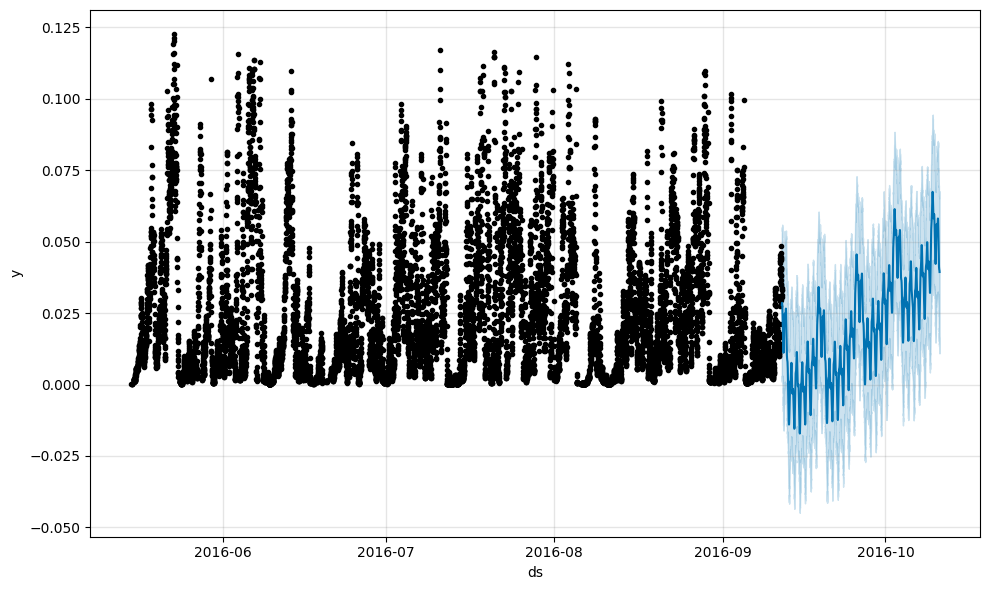

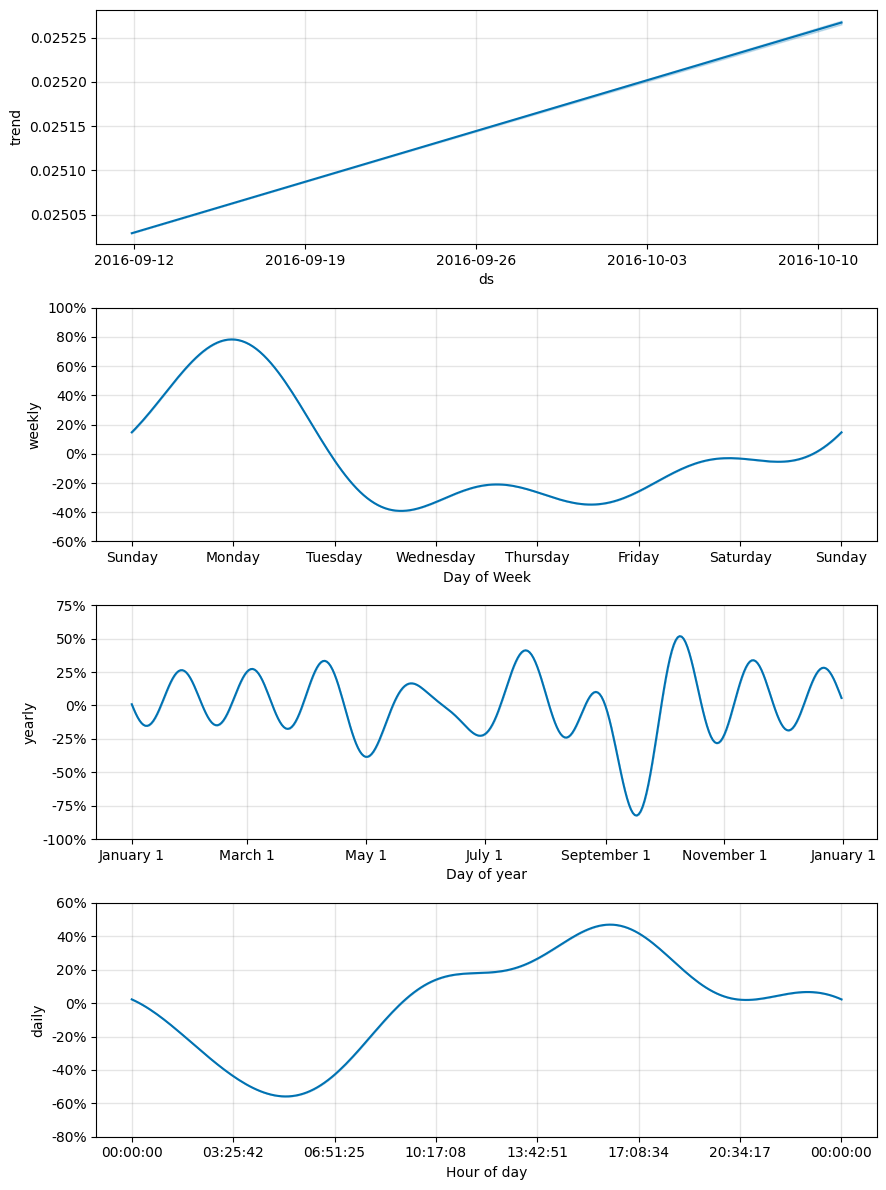

In [7]:
"""Trains and evaluates multiple Prophet models on distinct time periods.

This script loads a time series dataset, splits it into predefined periods,
and for each period, trains a separate Prophet model with a unique, custom
configuration. It evaluates each model's performance on a held-out test set
and saves the aggregated metrics to a CSV file. The script also generates
diagnostic plots for each model's forecast, allowing for visual inspection of
performance and components.
"""

def load_and_prepare_data(filepath):
    """Loads CSV data, parses dates, and sorts values by time.

    Args:
        filepath (str): The full path to the input CSV file. The CSV is
            expected to have at least 'ds' (datestamp) and 'y' (value) columns.

    Returns:
        pd.DataFrame: A DataFrame with 'ds' as datetime objects, sorted
            chronologically.
    """
    df = pd.read_csv(filepath)
    df['ds'] = pd.to_datetime(df['ds'])
    return df.sort_values('ds').reset_index(drop=True)

def filter_time_period(df, start_date, end_date):
    """Filters a DataFrame to include only data within a specific time range.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'ds' column.
        start_date (str): The start date of the period (e.g., 'YYYY-MM-DD').
        end_date (str): The end date of the period (e.g., 'YYYY-MM-DD').

    Returns:
        pd.DataFrame: A new DataFrame containing only the rows within the
            specified date range.
    """
    # Create a boolean mask for the date range.
    mask = (df['ds'] >= start_date) & (df['ds'] <= end_date)
    return df[mask].copy()

def split_data(df, split_frac=0.8):
    """Splits a DataFrame into training and test sets based on a fraction.

    This performs a simple chronological split, which is standard for time
    series data.

    Args:
        df (pd.DataFrame): The DataFrame to be split.
        split_frac (float): The fraction of data to be used for the training set.
            Defaults to 0.8.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the training
            DataFrame and the test DataFrame.
    """
    split_idx = int(len(df) * split_frac)
    return df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

def train_prophet_model(df_train, config, regressors=None):
    """Initializes, configures, and fits a Prophet model.

    Args:
        df_train (pd.DataFrame): The training data, containing 'ds', 'y', and
            any regressor columns.
        config (dict): A dictionary of Prophet hyperparameters.
        regressors (list[str], optional): A list of column names to be used as
            additional regressors. Defaults to None.

    Returns:
        Prophet: A fitted Prophet model instance.
    """
    # Initialize the Prophet model with all parameters from the config dictionary.
    m = Prophet(
        growth=config['growth'],
        changepoint_prior_scale=config['changepoint_prior_scale'],
        seasonality_mode=config['seasonality_mode'],
        yearly_seasonality=config['yearly_seasonality'],
        weekly_seasonality=config['weekly_seasonality'],
        daily_seasonality=config['daily_seasonality'],
        seasonality_prior_scale=config['seasonality_prior_scale'],
        holidays_prior_scale=config['holidays_prior_scale'],
        changepoint_range=config['changepoint_range'],
        interval_width=config['interval_width'],
        uncertainty_samples=config['uncertainty_samples']
    )
    # Add any specified additional regressors to the model.
    if regressors:
        for reg in regressors:
            m.add_regressor(reg)
    m.fit(df_train)
    return m

def evaluate_forecast(df_true, forecast):
    """Calculates evaluation metrics by comparing true values to a forecast.

    Args:
        df_true (pd.DataFrame): DataFrame containing the true values, with
            columns 'ds' and 'y'.
        forecast (pd.DataFrame): The forecast DataFrame produced by Prophet,
            containing 'ds' and 'yhat'.

    Returns:
        tuple: A tuple containing the MAE (float), RMSE (float), R2 score
            (float), and the combined comparison DataFrame.
    """
    # Align true values with forecasted values on the 'ds' column.
    comparison = df_true[['ds', 'y']].copy()
    comparison['yhat'] = forecast['yhat'].values
    comparison = comparison.dropna() # Drop rows with missing values.

    # Calculate standard regression metrics.
    mae = mean_absolute_error(comparison['y'], comparison['yhat'])
    rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
    r2 = r2_score(comparison['y'], comparison['yhat'])
    return mae, rmse, r2, comparison

def plot_forecast(comparison, title):
    """Plots the actual values against the forecasted values.

    Args:
        comparison (pd.DataFrame): A DataFrame with 'ds', 'y' (true), and
            'yhat' (forecast) columns.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(comparison['ds'], comparison['y'], 'ko', label='True')
    plt.plot(comparison['ds'], comparison['yhat'], 'b-', label='Prophet Forecast')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Parameters ===
# Path to the preprocessed data file.
data_path = '../data/AltenrheinWWTP_preprocessed.csv'
# Optional list of additional regressors. Set to None if not used.
regressors = None  # Optional: ['DO', 'Q_in', 'T']

# Define the specific time periods to model individually.
# Each tuple represents a (start_date, end_date) pair.
periods = [
    ('2016-01-01', '2016-03-31'),
    ('2016-03-01', '2016-05-15'),
    ('2016-05-15', '2016-10-31')
]

# Define a list of hyperparameter configurations for Prophet.
# Each dictionary corresponds to a period in the `periods` list above.
prophet_configs = [
    {
        'growth': 'linear',
        'changepoint_prior_scale': 0.0090,
        'seasonality_mode': 'multiplicative',
        'yearly_seasonality': 'auto',
        'weekly_seasonality': 'auto',
        'daily_seasonality': True,
        'seasonality_prior_scale': 20.0,
        'holidays_prior_scale': 10.0,
        'changepoint_range': 0.8,
        'interval_width': 0.8,
        'uncertainty_samples': 1000
    },
    {
        'growth': 'linear',
        'changepoint_prior_scale': 0.001,
        'seasonality_mode': 'additive',
        'yearly_seasonality': False,
        'weekly_seasonality': False,
        'daily_seasonality': True,
        'seasonality_prior_scale': 30.0,
        'holidays_prior_scale': 10.0,
        'changepoint_range': 0.8,
        'interval_width': 0.8,
        'uncertainty_samples': 1000
    },
    {
        'growth': 'linear',
        'changepoint_prior_scale': 0.002050001,
        'seasonality_mode': 'multiplicative',
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'seasonality_prior_scale': 50.0,
        'holidays_prior_scale': 10.0,
        'changepoint_range': 0.8,
        'interval_width': 0.8,
        'uncertainty_samples': 1000
    }
]

# === Load Data ===
df = load_and_prepare_data(data_path)

# === Loop through periods ===
# This list will store the performance metrics for each period.
all_metrics = []

# Iterate through each period and its corresponding configuration.
for idx, ((start_date, end_date), config) in enumerate(zip(periods, prophet_configs), 1):
    print(f"\n\n=== Period {idx}: {start_date} to {end_date} ===")

    # Filter the main DataFrame to get data for the current period.
    df_period = filter_time_period(df, start_date, end_date)

    # Skip periods with insufficient data to train a model.
    if len(df_period) < 10:
        print("Not enough data in this period – skipping.")
        continue

    # Plot the actual values for the current period for visual inspection.
    plt.figure(figsize=(12, 4))
    plt.plot(df_period['ds'], df_period['y'], 'k.-')
    plt.title(f"Period {idx} Time Series")
    plt.xlabel("Date")
    plt.ylabel("y")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Split the period's data into training and test sets.
    df_train, df_test = split_data(df_period)

    # Train a Prophet model using the period-specific configuration.
    model = train_prophet_model(df_train, config=config, regressors=regressors)

    # --- Evaluation ---
    # Evaluate performance on the training data (to check for overfitting).
    forecast_train = model.predict(df_train[['ds']])
    mae_train, rmse_train, r2_train, _ = evaluate_forecast(df_train, forecast_train)

    # Evaluate performance on the unseen test data.
    forecast_test = model.predict(df_test[['ds']])
    mae_test, rmse_test, r2_test, comparison_test = evaluate_forecast(df_test, forecast_test)

    # Store the calculated metrics in a dictionary.
    all_metrics.append({
        'Period': f"Period {idx}",
        'MAE_Train': mae_train,
        'RMSE_Train': rmse_train,
        'R2_Train': r2_train,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'R2_Test': r2_test
    })

    # --- Visualization ---
    # Plot the forecast for the test set against the true values.
    plot_forecast(comparison_test, f"Prophet Forecast - Period {idx}")

    # Use Prophet's built-in plotting functions for diagnostics.
    # The first plot shows the overall forecast with uncertainty intervals.
    model.plot(forecast_test)
    # The second plot breaks down the forecast into trend and seasonal components.
    model.plot_components(forecast_test)

# === Save all metrics ===
# Convert the list of metric dictionaries to a DataFrame.
metrics_df = pd.DataFrame(all_metrics)
# Save the metrics to a CSV file for later analysis.
metrics_df.to_csv('../results/Prophet_metrics_by_period.csv', index=False)
print("\nAll metrics saved to 'Prophet_metrics_by_period.csv'")
print(metrics_df)